# John Wu
# CSE 5524
# 10/13/22
### Libraries

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import morphology
# plt.rcParams['figure.figsize'] = [20, 20]

### 1) Download a color image from the web. Run the SLIC superpixel segmentation algorithm provided in Matlab or Python and experiment with the target number of superpixels and compactness. Display and discuss your results. [3 pts]

    Matlab: [L, NumLabels] = superpixels(img, N, Name, Value)
    Python: from skimage.segmentation import slic
    segments_slic = slic(img, n_segments=250, compactness=10)

##### Original Image

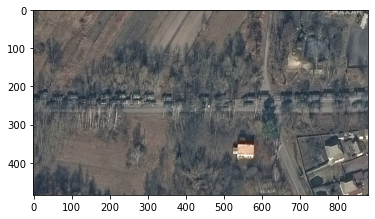

In [59]:
colorIm = plt.imread("colorIm.png")
plt.imshow(colorIm)


##### Original 250 by 250, our goal is to take this satellite image and see if we can't use superpixels to segmentate specific features like the tiny vehicles above in the satellite imagery.

(485, 879)


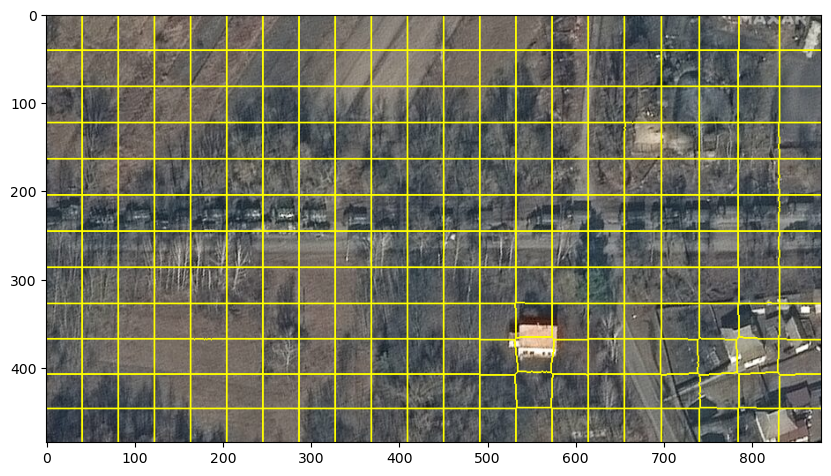

In [60]:
segments_slic = slic(colorIm, n_segments=250, compactness=250)
print(segments_slic.shape)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_250_250.png')

#### nseg = 1000, compactness= 1000 - Does a decent job with resolution with the squares becoming smaller, but shape is too squareish (compactness too high).

(485, 879)


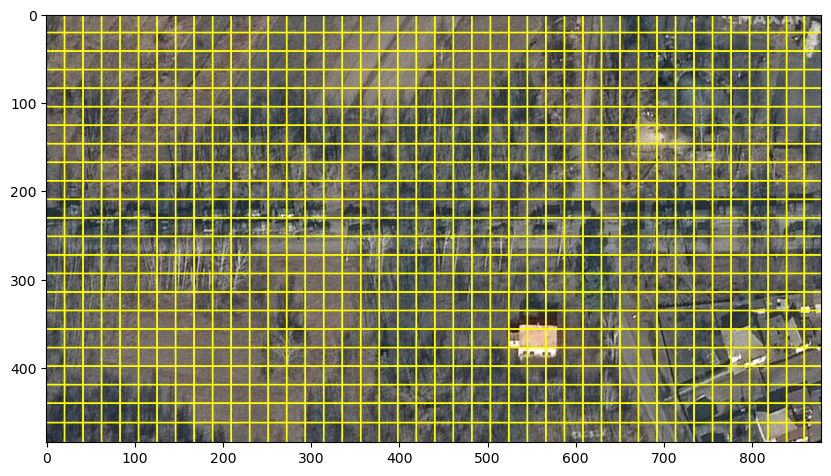

In [61]:
segments_slic = slic(colorIm, n_segments=1000, compactness=1000)
print(segments_slic.shape)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_1000_1000.png')

##### Now, let's try to get really precise, nSeg=1000, compactness=10. We're getting a little bit of some features. It's better, but fails to get the shapes of the vehicles exactly. Maybe reduce the number of superpixels.

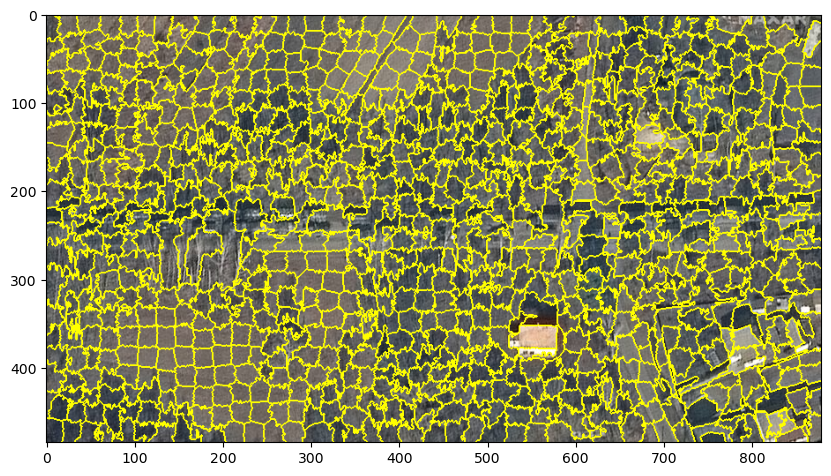

In [62]:
segments_slic = slic(colorIm, n_segments=1000, compactness=10)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_1000_10.png')

##### nSeg = 1000, compactness = 1. Just in case, we tried even smaller compactness. Now we can see some interesting details in the bottom right, but let's try less superpixels. This seems to not do so well as it draws edges around nothing. Note that reducing the compactness has made it not work very well at all.

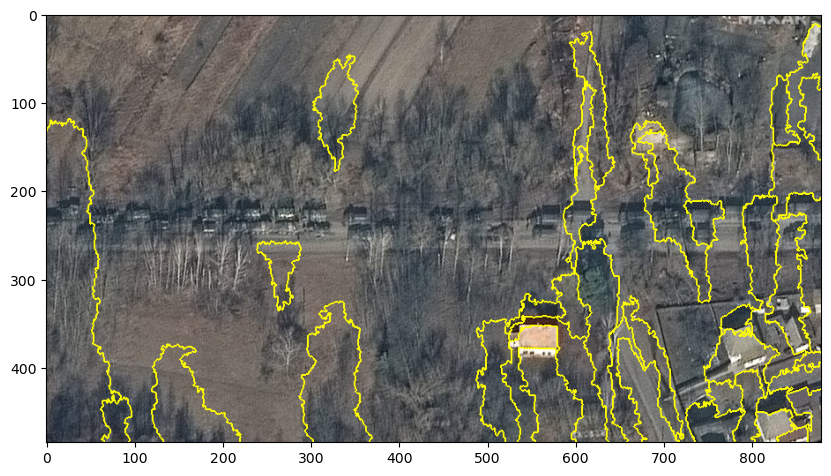

In [63]:
segments_slic = slic(colorIm, n_segments=1000, compactness=1)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_1000_1.png')

##### Let's try going back to compactness=10, and just halving the number of segments.

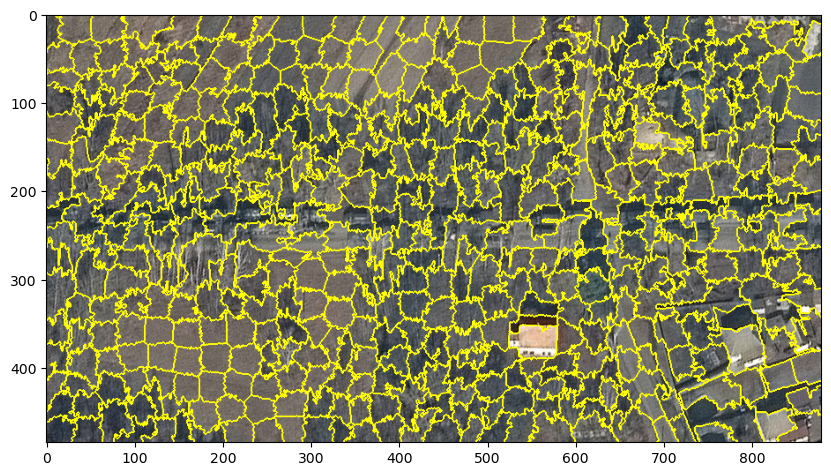

In [64]:
segments_slic = slic(colorIm, n_segments=500, compactness=10)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_500_10.png')

##### How low of nSegments can we go? nSegments = 20, compactness = 10. Turns out not using enough superpixels leads to problems capture fine resolution features.

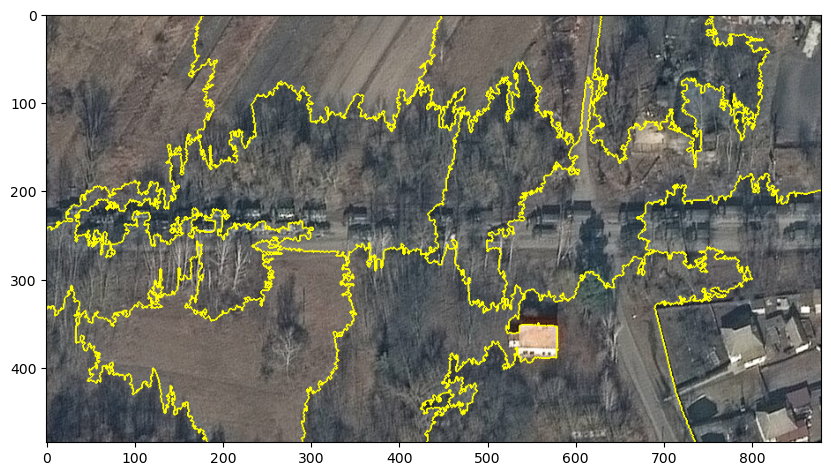

In [65]:
segments_slic = slic(colorIm, n_segments=20, compactness=10)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_20_10.png')

#### Let's see if we can't increase compactness to get some squareish features as vehicles are square. Compactness = 20, N_segments=500.

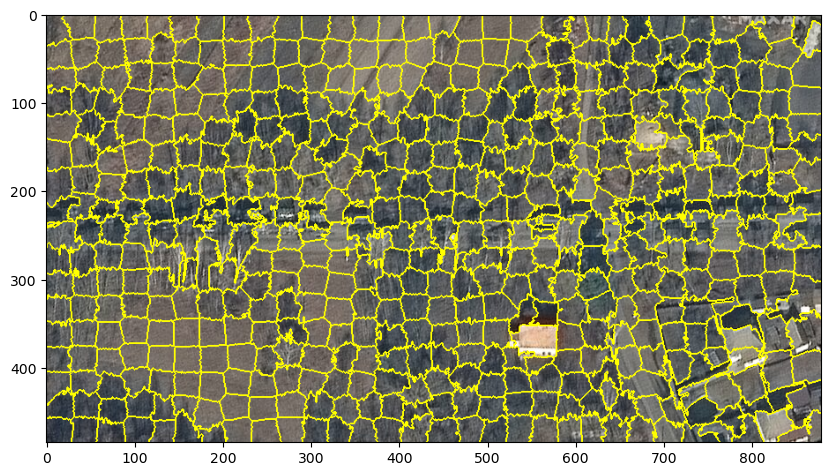

In [66]:
segments_slic = slic(colorIm, n_segments=500, compactness=20)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_500_20.png')

##### After trying a bunch of different random combos, the best one was so far was n_segments=150, compactness = 20.

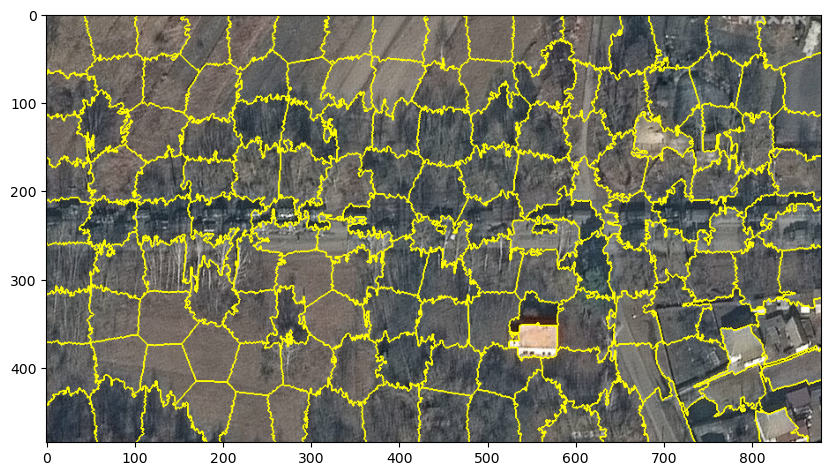

In [67]:
segments_slic = slic(colorIm, n_segments=150, compactness=20)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mark_boundaries(colorIm, segments_slic))
plt.savefig('p1_150_20.png')

#### Results and Discussion: In general, increasing the number of segments created more "superpixels" and increasing the compactness made each pixel more square, which makes sense because suppose m or compactness was infinite, then we care substantially more about the spatial positioning of pixels around each superpixel. Also, interestingly enough, more superpixels is not always better, having too many may result in too many tiny superpixels which may not image segmentate the features you care the most about as if we went too small, we were unable to capture the convoy. Use too few segments and we fail to capture any small features. Furthermore, using too much compactness is also bad, because it becomes too "square" and most objects are not squares. For instance, in the 1000 compactness one, we were unable to even superpixel or segmentate the bottom house or any of the fields. Using too small of a compactness value, however, completely breaks the algorithm and essentailly did nothing as observed with compactness = 1. So, tuning this parameter is key to getting what you want out of your image. As one final regard, it is super interesting to see how camouflage is even important in terms of dealing with satellite imagery. It was actually pretty challenging for this algorithm to be able to capture all of the individual convoy features (that fortunately the human eye can), because all the Russian vehicles are all this grayish color, which blends in with the grayish features of the satellite image environment (color similarity is I guess important for war). 

### 2) There’s an elephant in the room. Can you find it? Use the “template” template.png and search for it in the “search image” search.png using color-based NCC (make sure the standard deviation is “unbiased” with N-1). (Note: the template did NOT come from the search image.) Assume the origin is in the center of the template image (Note: there should be a wide border around the search image where the metrics cannot be computed).


### Sort the resulting scores from best to worst. Plot all of the sorted scores (1-D plot) and show the patches corresponding to the 1st , 2nd , 5th , 10th , 100th , and 500 th best matches. Compare the results. [5 pts]

##### Search and its template.

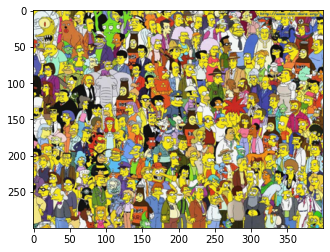

In [68]:
searchIm = plt.imread("search.png")
plt.imshow(searchIm)

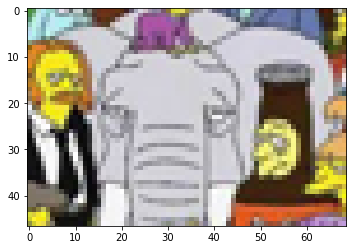

In [69]:
templateIm = plt.imread("template.png")
plt.imshow(templateIm)

##### Functions that will be used to search.

In [70]:
def getAverageRGBN(image):
  """
  Given np Image, return average value of color as (r, g, b)
  """
  # get image as numpy array
  # get shape
  w,h,d = image.shape
  # change shape
  image = image.reshape(w*h, d)
  # get average
  return (np.mean(image, axis=0))
# NCC
# assume templateDiffs are a cube of differences in x,y,rgb plane
def ncc(templateDiffs, templateStd, patchIm):
    nRGB = templateIm.shape[2]
    patchMeans = getAverageRGBN(patchIm)#np.zeros(nRGB)
    patchStd = np.zeros(nRGB)
    nPixels = templateIm.shape[0] * templateIm.shape[1]
    for color in range(templateIm.shape[2]): # get rgb
        patchStd[color] = np.std(patchIm[:,:,color],ddof=1) # unbiased
    NCC = 0
    # get differences, all vectorized because otherwise it's too slow without C mappings.
    patchDiffs = np.zeros(patchIm.shape)
    for c in range(nRGB):
        patchDiffs[:, :, c] = patchIm[:,:,c] - patchMeans[c]
    NCC = np.multiply(patchDiffs, templateDiffs)
    for c in range(nRGB):
      denom = templateStd[c] * patchStd[c] # standard deviation term
      NCC[:,:,c] = np.divide(NCC[:,:,c], denom)
    
    NCC /= (nPixels - 1) 
    NCC = np.sum(NCC)
    return NCC
  
def ncc_scan(im, templateIm):
  windowRows = templateIm.shape[0]
  windowCols = templateIm.shape[1]
  finalOriginRow = im.shape[0] - windowRows + 1
  finalOriginCol = im.shape[1] - windowCols + 1
  bestOriginRow = 0
  bestOriginCol = 0
  bestDistance = -np.Inf
  allNCCs = np.zeros((finalOriginRow, finalOriginCol))
  
  templateMeans = np.zeros(templateIm.shape[2])
  templateStd = np.zeros(templateIm.shape[2])
  templateDiffs = np.zeros(templateIm.shape)
  for color in range(templateIm.shape[2]):
    templateMeans[color] = np.mean(templateIm[:,:,color])
    templateStd[color] = np.std(templateIm[:,:,color],ddof=1)
  for c in range(templateIm.shape[2]):  
    templateDiffs[:,:,c] = templateIm[:,:,c] - templateMeans[c]
  for row in range(finalOriginRow):
      for col in range(finalOriginCol):
          candidatePatch = im[row:(row + windowRows), col:(col+windowCols),:]
          nccScore = ncc(templateDiffs, templateStd, candidatePatch)
          allNCCs[row, col] = nccScore
          if nccScore > bestDistance:
              bestOriginRow = row
              bestOriginCol = col
              bestDistance = nccScore
  return allNCCs, (bestOriginRow, bestOriginCol) # return a matrix of all the distances and best row/col

In [71]:
# print(searchIm.shape)
# print(templateIm.shape)
nccs, bestOrigin = ncc_scan(searchIm, templateIm)

##### We should get the template image back, note that the above operation should take approximately 16.6 seconds.

(82, 71)


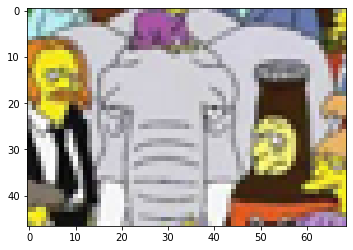

In [72]:
print(bestOrigin)
plt.imshow(searchIm[bestOrigin[0]:bestOrigin[0] + templateIm.shape[0], bestOrigin[1]:bestOrigin[1] + templateIm.shape[1]])

##### For personal interest, we can plot all the NCCs values, note that brighter is better or more likely NCC score. Cool enough, its relative position is where the elephant is in the search.png picture.

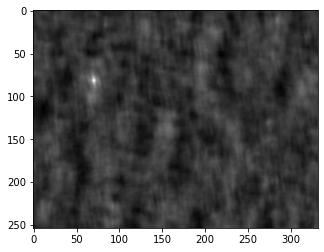

In [73]:
plt.imshow(nccs,cmap='gray')

##### Sort the numpy array of top left scores from biggest NCC value to smallest and plot the scores and matches.

In [74]:
# Note that we still want to keep all the "origin" pixel values. First create a dictionary of tuples of positions and their corresponding NCC
sortedNCC = {}
for row in range(nccs.shape[0]):
    for col in range(nccs.shape[1]):
        sortedNCC[(row,col)] = nccs[row,col]

sortedNCC = dict(sorted(sortedNCC.items(), key=lambda item: item[1],reverse=True)) # should return in descending order
coordinates = list(sortedNCC.keys())
sortedScores = sortedNCC.values()


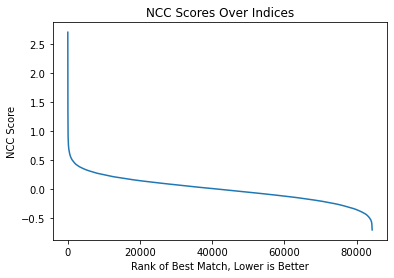

In [75]:
# Plotting score best to worst wise.
plt.title("NCC Scores Over Indices")
plt.xlabel("Rank of Best Match, Lower is Better")
plt.ylabel("NCC Score")
plt.plot(np.arange(1,len(sortedScores) + 1,1), sortedScores)
plt.savefig("p2_NCCScoresPlot.png")

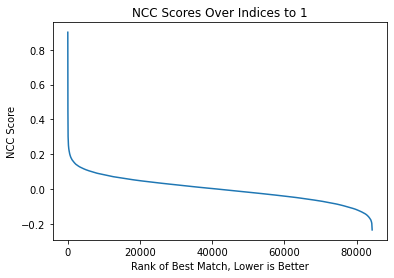

In [76]:
# Plotting score best to worst wise.
plt.title("NCC Scores Over Indices to 1")
plt.xlabel("Rank of Best Match, Lower is Better")
plt.ylabel("NCC Score")
sortedScores = np.array(list(sortedScores))
plt.plot(np.arange(1,len(sortedScores) + 1,1), sortedScores / 3)
plt.savefig("p2_NCCScoresPlotOne.png")

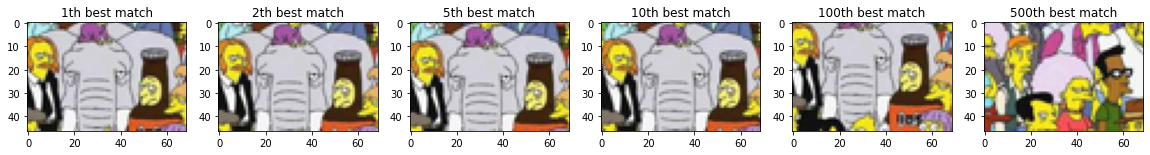

In [77]:
# now that we have all the coordinates, let's do some plotting with the 1st, 2nd, etc. places
places = [0,1,4,9,99,499]
f, axs = plt.subplots(1, len(places), figsize=(20,20))
i = 0
for place in places:
    row, col = coordinates[place]
    axs[i].imshow(searchIm[row:row+templateIm.shape[0], col:col+templateIm.shape[1],:])
    axs[i].set_title( str(place + 1) + "th best match")
    i+=1
plt.savefig("p2_finalMatches.png")

#### Results/Discussion: To compare each of the results, first off, the 1st best match is basically almost the same thing as the template seen above.  The 2nd best match looks almost the same as the 1st best match (even if it's known to be 1 pixel off). The 5th best match also looks pretty much the same. The 10th and 100th best matches are just displaced versions of the 1st best match where for instance the 10th shifts to the right and the 100th shifts up a little. However, by rank 500, which interestingly enough is around where NCC drops off to around 1000 (from 4000 in the NCC 1D Score plot) is of a completely different image and is not of the elephant. Since it is able to basically capture the elephant for up to the 100th best match, this template match seems to be at least successful for these types of images (which in this case are very colorful).